In [2]:
# HIDDEN

from datascience import *
import numpy as np
from scipy import stats

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Analyzing Randomized Controlled Experiments

Early in the course we noted that some questions of inference involve an attempt to establish causality: did a treatment *cause* an observed effect? As we saw, this question is harder to answer than if we had just asked whether the treatment is associated with the effect.

One setting in which it is possible to establish causality is a randomized controlled experiment, also known as a randomized controlled trial or RCT. Recall that in such an experiment, participants are assigned randomly into treatment and control groups. At the end of the experiment, the results of the two groups are compared. If they are significantly different, the difference can be explained as a result of the treatment. 

The randomization allows us to make this conclusion about causality. Because of the random assignment, the participants in the two groups are likely to be similar apart from the treatment. So observed differences in the outcome can be ascribed to the treatment.

With the methods of inference that we now have at our disposal, we are well equipped to analyze the results of randomized controlled experiments and see whether the treatment had an effect.

### Assessing a New Medical Procedure

One such experiment involved a new method for drawing blood intravenously. The standard IV method involves tying a band around the patient's arm to make it easier to insert a needle into the vein. The new treatment essentially replaced the tied band with something like a rubber band that can be slipped on. 

Here are the data. There were 505 subjects in the study. Of these, 241 were randomized into the control group and received the standard treatment. The remainder became the treatment group and received the new treatment. The table ``iv`` contains the data. We will ignore the columns of height and weight and just focus on the other two. The ``Group`` column contains the group label: 0 stands for control and 1 for treatment. The ``success`` column contains a 1 if the needle was inserted successfully, and 0 otherwise. There was a clear definition of "success" involving the number of attempts at insertion and the time involved.

In [3]:
iv = Table.read_table('IV.csv').drop('sbp')
iv

Group,height,weight,success
1,74,150,1
1,72,142,1
1,72,160,1
1,72,160,0
1,71,100,1
1,66,200,0
1,66,145,0
1,68,120,1
1,72,200,1
1,62,162,1


### The Observed Difference

It is natural to compare the proportion of successes in the two groups. Somewhat surprisingly, the success rate in the control group is higher: 95% compared to 78% in the treatment group.

In [4]:
control = iv.where(iv['Group'],0)
treatment = iv.where(iv['Group'],1)

In [5]:
control_mean = np.count_nonzero(control['success'])/control.num_rows
control_mean

0.950207468879668

In [6]:
treatment_mean = np.count_nonzero(treatment['success'])/treatment.num_rows
treatment_mean

0.7803030303030303

Notice that in the code we are calling both the proportions "means": `control_mean` and `treatment_mean`. That is because a proportion is just a mean of 0's and 1's.

The observed difference (computed as "control - treatment") is about 0.17.

In [12]:
control_mean - treatment_mean

0.16990443857663773

### An Abstract Model

Is the difference due to chance? To answer this question, we must first be clear about exactly what is being tested. Unlike the data we have analyzed in the past, there is no large population from which a sample was drawn at random. Rather, a group of 505 people was split randomly into treatment and control groups. So what exactly is the question about?

From a practical perspective, the question is motivated by the possibility that it is just easier to insert IV needles into some patients than others, and that perhaps many of these patients were placed in the control group just by chance. 

Formally, the question is about an *abtract model*. The model says that before the experiment is conducted, each person has a potential score of 1 or 0 that he/she would get if assigned to the control group, and also a potential score that he/she would get if assigned to the treatment group. For each patient, we only get to see one of these two hypothetical scores. Which one we get to see depends on chance: the chance that determines whether the patient is assigned to the treatment group or to the control group.

There are 505 people in the experiment, so there are 505 of these potential control scores and 505 potential treatment scores. We get to see the control scores of 241 randomly picked patients, and the treatment scores of the *remaining* 264 patients. 

The question, then, is about the difference between the proportion of 1's among all hypothetical control scores and the proportion of 1's among all hypothetical treatment scores.

### The Null and Alternative Hypotheses

**Null Hypothesis:** The proportion of 1's among all 505 potential control scores is the same as the proportion of 1's among all 505 potential treatment scores. The difference in observed scores in the sample is due to chance.

**Alternative Hypothesis:** The proportions of 1's in the two groups of 505 potential scores are different.

As our test statistic, we will use the difference between the proportions of 1's in the control sample and the treatment sample. As we saw earlier, the observed value of the test statistic is about -0.17.

### Bootstrap A/B test

We can use a bootstrap A/B test to decide between the two hypotheses. This is a test we developed in an earlier section; we will simply apply it here. To review the main method, note that under the null hypothesis the two groups of scores arise from the same underlying population, and so we can bootstrap the combined sample to create new samples of "treatment" and "control" scores.

For ease of reference, here is the code we developed for the function `bootstrap_AB_test`. The code calculates the difference between means as "mean of the group labeled 0 - mean of the group labeled 1". That was also how we calculated the observed difference in means. In the table `iv`, the control group is labeled 0 and the treatment group 1. Our calculation was "control mean - treatment mean = 0.17".

In [9]:
"""Bootstrap A/B test for the difference in the mean response
Assumes A=0, B=1"""

def bootstrap_AB_test(table, categories, values, repetitions):
    
    # Sort the sample table according to the A/B column; 
    # then select only the column of effects.
    response = table.sort(categories).select(values)
    
    # Find the number of entries in Category A.
    n_A = table.where(categories, 0).num_rows
      
    # Calculate the observed value of the test statistic.
    meanA = np.mean(response.column(values)[:n_A])
    meanB = np.mean(response.column(values)[n_A:])
    observed_difference = meanA - meanB
    
    # Run the bootstrap procedure and get a list of resampled differences in means
    diffs = []
    for i in range(repetitions):
        resample = response.sample(with_replacement=True)
        d = np.mean(resample.column(values)[:n_A]) - np.mean(resample.column(values)[n_A:])
        diffs.append([d])
    
    # Compute the bootstrap empirical P-value
    diff_array = np.array(diffs)
    empirical_p = np.count_nonzero(abs(diff_array) >= abs(observed_difference))/repetitions
    
    # Display results
    differences = Table().with_column('diff_in_means', diffs)
    differences.hist(bins=20,normed=True)
    plots.xlabel('Approx null distribution of difference in means')
    plots.title('Bootstrap A/B Test')
    print("Observed difference in means: ", observed_difference)
    print("Bootstrap empirical P-value: ", empirical_p)

Let us perform the test. The arguments of `bootstrap_AB_test` are the name of the table, the column label of the group identifier, the column label of the response (1 or 0 in this example), and the desired number of replications.

Observed difference in means:  0.169904438577
Bootstrap empirical P-value:  0.0


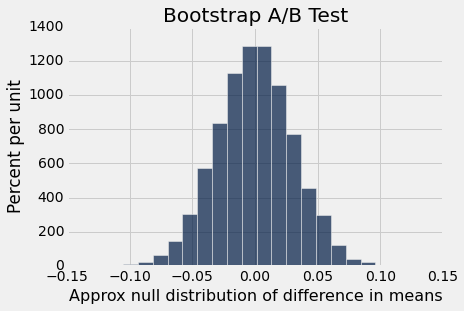

In [14]:
bootstrap_AB_test(iv, 'Group', 'success', 10000)

### Conclusion

The empirical P-value is 0; none of the bootstrap replications yielded a difference as big as the observed. The data support the alternative hypothesis that the difference is not due to chance. 

Because the data are from a randomized controlled experiment, the only difference between the two groups being compared is the treatment. Therefore it is reasonable to conclude that the difference is due to the treatment.

We therefore conclude that the new treatment did have an effect. It was not a good effect. The test statistic we computed was "control mean - treatment mean = 0.17". The positive sign tells us that the control group had a higher success rate. Because the data are from a randomized contolled experiment, we can therefore conclude that the treatment hurt. Based on these data, we hope that medical practitioners continue to use the standard method for drawing blood.